TODO:
1. Найти распределение вероятностей для каждого состояния
2. Построить график количества людей в системе от времени
3. Построить график среднего времени нахождения клиента в системе от времени

In [77]:
import threading
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as napas

In [61]:
N_CLIENTS = 100

LAMBDA = 1
MU1 = 2
MU2 = 2

LOGGING = False

clients_list = []

event = threading.Event()
event.set()

In [62]:

timings = []

def get_state(chair1, chair2) -> str:
    if (not chair1.is_busy and not chair2.is_busy):
        return '00'
    if (not chair1.is_busy and chair2.is_busy):
        return '01'
    if (chair1.is_busy and not chair2.is_busy):
        return '10'
    if(chair1.is_blocked and chair2.is_busy):
        return 'b1'
    if (chair1.is_busy and chair2.is_busy):
        return '11'

In [63]:
class Client:
    def __init__(self, id):
        self.id = id
        self.start_time = None
        self.finish_time = None


In [64]:
class Chair1:
    def __init__(self):
        self.is_busy = False
        self.is_blocked = False
    
    def serving(self, client: Client):
        random.seed()
        ksi = random.expovariate(MU1)
        self.is_busy = True
        if LOGGING:
            print(f'client {client.id} is starting serving on the 1 chair')
        time.sleep(ksi)
        if LOGGING:
            print(f'client {client.id} finished serving on the 1 chair')
        return ksi
    

In [65]:
class Chair2:
    def __init__(self):
        self.is_busy = False
    
    def serving(self, client: Client):
        random.seed()
        ksi = random.expovariate(MU2)
        self.is_busy = True
        if LOGGING:
            print(f'client {client.id} is starting serving on the 2 chair')
        time.sleep(ksi)
        if LOGGING:
            print(f'client {client.id} finished serving on the 2 chair')
        return ksi

In [66]:
def append_timing(timings: list, state: str, time):
    if len(timings) != 0 and timings[-1][0] == state:
        timings.pop()
    timings.append((state, time))

In [67]:
def serving(client: Client, chair1: Chair1, chair2: Chair2, start_time):
    # if LOGGING:
    #     print(f'CLIENT {client.id} STARTED SERVING')
    client.start_time = time.time() - start_time

    t = time.time() - start_time
    append_timing(timings, get_state(chair1, chair2), t)
    t_1 = t+chair1.serving(client)
    append_timing(timings, get_state(chair1, chair2), t_1)

    if not event.is_set():
        chair1.is_blocked = True
        # if LOGGING:
        #     print(f'client {client.id} is waiting for chair 2')

    t = time.time() - start_time
    event.wait()
    event.clear()
    t_w = time.time() - t

    t = time.time() - start_time
    append_timing(timings, get_state(chair1, chair2), t)
    chair1.is_busy = False
    chair1.is_blocked = False
    t_2 = t+chair2.serving(client)
    append_timing(timings, get_state(chair1, chair2), t_2)
    
    chair2.is_busy = False
    
    event.set()
    client.finish_time = t_2
    clients_list.append(client)


In [68]:
chair1 = Chair1()
chair2 = Chair2()

serving_start = time.time()

start_time = time.time()

for i in tqdm(range(N_CLIENTS)):
    random.seed()
    ksi = random.expovariate(LAMBDA)
    time.sleep(ksi)
    if not chair1.is_busy:
        x = threading.Thread(target=serving, args=(Client(i + 1), chair1, chair2, start_time))
        x.start()   
    # else:
    #     if LOGGING:
    #         print(f'CLIENT {i + 1} WAS REJECTED')
    
x.join()
# serving_end = time.time()


total_time = clients_list[-1].finish_time

# if LOGGING:
#     print(f'Serving finished, total time: {total_time}')
#     for client in clients_list: 
#         print(f'id: {client.id}, time in system: {client.finish_time - client.start_time}')

100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


In [69]:
probs = {'00': .0,
         '10': .0,
         '01': .0,
         '11': .0,
         'b1': .0}

prev_time = 0
for item in timings:
    state = item[0]
    time = item[1]
    probs[state] += (time - prev_time) / total_time
    prev_time = time  
    
for k,v in probs.items():
    print(f'pi_{k} ~ {v:.3f}')

pi_00 ~ 0.430
pi_10 ~ 0.283
pi_01 ~ 0.187
pi_11 ~ 0.038
pi_b1 ~ 0.063


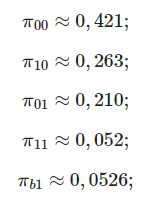

In [95]:
times = []
states = []
for state, time in timings:
    if state == 'b1':
        _state = '11'
    else:
        _state = state
    states.append(int(_state[0]) + int(_state[1]))
    
for client in clients_list:
    times.append(client.finish_time - client.start_time)

In [96]:
x = []
y = []
for i, item in enumerate(timings):
    state = item[0]
    time = item[1]
    if state == 'b1':
        _state = '11'
    else:
        _state = state
    y.append((int(_state[0]) + int(state[1]) + sum(states[:i])) / (len(y) + 1))
    x.append(time)

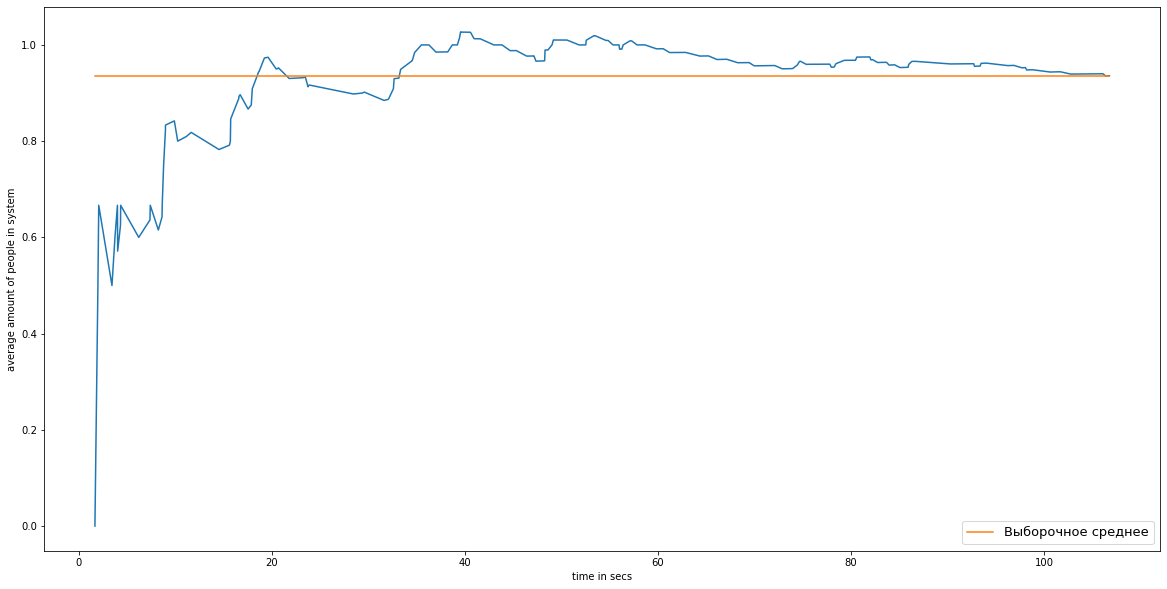

In [97]:
plt.figure(figsize=(20, 10))
plt.plot(x, y)
plt.plot(x, napas.full(len(x), napas.mean(states)), label='Выборочное среднее')
plt.xlabel('time in secs')
plt.ylabel('average amount of people in system')
plt.legend(loc='lower right', fontsize=13)

In [98]:
x = []
y = []
for i, client in enumerate(clients_list):
    x.append(client.finish_time)
    y.append((client.finish_time - client.start_time + sum(times[:i])) / (len(y) + 1) )

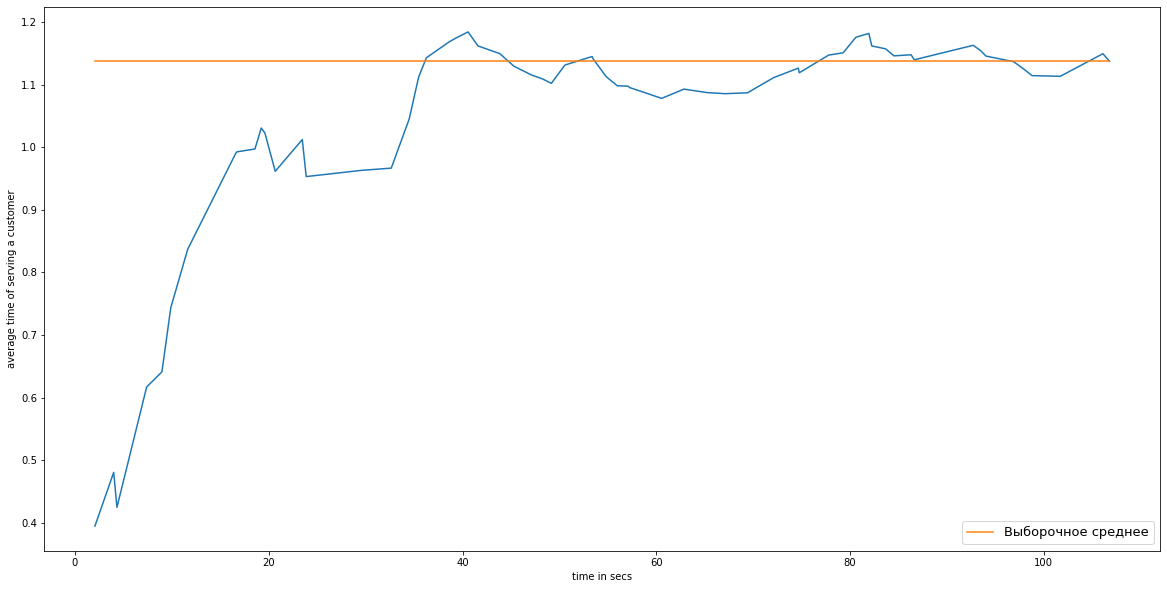

In [99]:
plt.figure(figsize=(20, 10))
plt.plot(x, y)
plt.plot(x, napas.full(len(x), napas.mean(times)), label='Выборочное среднее')
plt.xlabel('time in secs')
plt.ylabel('average time of serving a customer')
plt.legend(loc='lower right', fontsize=13)